# Introduction to Neural Networks in PyTorch
In this practical, you will build a simple neural network to classify images and experiment with various neural network components, including activation functions, regularization, and optimization methods.

### Objectives
- Build a feedforward neural network for image classification.
- Experiment with different activation functions and observe their effects.
- Apply regularization techniques to prevent overfitting.
- Tune the optimization process and observe the impact of different optimizers and learning rates.
- Learn model checkpointing and Early stopping
- Set up WandB
### Required packages:

[1] [pytorch](https://pytorch.org/docs/stable/index.html) is library widely used for bulding deep-learning frameworks

[2] [TorchVision](https://pytorch.org/vision/stable/index.html) you can use available datasets that include one you are required to use in this tutorial (CIFAR10) and also use augmentations (meaning you can increase data variability for improved accuracy and model generalisation)

[3] [matplotlib](http://matplotlib.org) can be used for plotting graphs in python

[4] [Wandb](https://wandb.ai/site) is used to automate visualization of your training development - It is important to observe it.


In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from torch.utils.data import DataLoader, random_split



## Step 1: Load and Preprocess the Data
We will use the MNIST dataset of handwritten digits from 0 - 9. Each image is grayscale and has a size of 28x28 pixels.

### Instructions
1. Load the dataset using `torchvision.datasets`.
2. Apply standard normalization to ensure consistent training results.
3. Use `DataLoader` to batch the data. Batch size refers to the number of training examples utilized in one iteration

The output of torchvision datasets are PILImage images of range [0, 1]. 
We can transform them to Tensors of normalized range [-1, 1] 
using formula 

 `normalized_pixel = (pixel−mean)/std`


- Transform to Tensors:
https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ToTensor

- Normalize:
https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Normalize

- We can compose these two trasnformation using function 'Compose'
https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.Compose

Read more on different transform operations:
https://pytorch.org/vision/stable/transforms.html

**Data preprocessing: <br>**
*Step [1]:* Transform --> Normalise your data - mean and std (e.g., if color then normalise all three channels)
e.g., torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

*Step [2]:* Transform --> Always convert data to ToTensor (you can do **step 1, 2, and 3** in one line as done in this tutorial)

*Step [3]:* Make [DataLoaders](https://pytorch.org/docs/stable/data.html): It represents a Python iterable over a dataset

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) 
])

# Load the dataset
dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)



# ###########################################
# from torch.utils.data import Subset
# indices = np.random.choice(len(dataset), 100, replace=False)
# dataset = Subset(dataset, indices)

# ##############################################



# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size   # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

## Visualize Sample Data
Let's display a few sample images to understand the dataset.


torch.Size([64, 1, 28, 28])
torch.Size([64])


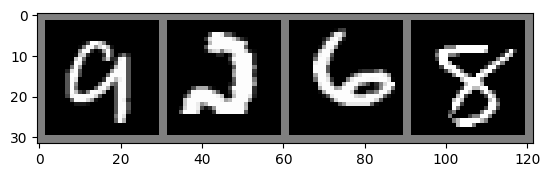

Labels: tensor([9, 2, 6, 8])


In [3]:
# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)  # Use next(dataiter) instead of dataiter.next()


print('The size of image variable is Batchsize , Channel, Height, Width ',images.shape) # Batchsize , Channel, Height, Width 
print('The size of label is Batchsize i.e. ',labels.shape)  # array with label in batchsize 

# Show images
imshow(torchvision.utils.make_grid(images[:4]))
print('Labels:', labels[:4])


## Step 2: Define a Simple Neural Network
We'll start by defining a simple feedforward neural network with one hidden layer.

`nn.Linear` module automatically creates a linear transformation with bias and weight tensors that can be used in the forward feed. You can access these using model.hidden.weight or model.hidden.bias.


Remember the size of an image in MNIST is 1x28x28. Based on that think carefuly about what the input dimension of your first layer should be.

Remember the total number of unique classes (images) in MNIST is 10. Based on that think carefuly about what the output dimension of your last layer should be.



In [14]:
class SimpleNN(nn.Module):
    """
    A simple Multi-Layer Perceptron (MLP) model for image classification using fully connected layers.
    
    This neural network has three layers:
      - Input Layer (fc1): Takes a flattened 28x28 input image and maps it to 128 neurons.
      - Hidden Layer (fc2): Maps the output of the first layer to 64 neurons.
      - Output Layer (fc3): Maps the 64 neurons to 10 output neurons.

    Parameters:
    -----------
    activation_function : nn.Module
        The activation function to be applied after each fully connected layer (e.g., ReLU, Sigmoid, Tanh).
    
    Methods:
    --------
    forward(x):
        Defines the forward pass of the network. Applies the activation function after each layer, except the final layer.
    
    Example:
    --------
    model = SimpleNN(activation_function=nn.ReLU())
    output = model(input_image)
    
    Notes:
    ------
    - `x.view(-1, 28*28)` reshapes the input images from (batch_size, 1, 28, 28) to (batch_size, 784) for the fully connected layer.
    - Each activation function transforms layer outputs, introducing non-linearity and enabling the network to learn complex patterns.
    """

    def __init__(self, activation_function):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 640)  # Input layer: Flatten 28x28 to 784 and map to 128
        self.fc2 = nn.Linear(640, 540)  # Input layer: Flatten 28x28 to 784 and map to 128
        self.fc3 = nn.Linear(540, 320)  # Input layer: Flatten 28x28 to 784 and map to 128
        self.fc4 = nn.Linear(320, 128)  # Input layer: Flatten 28x28 to 784 and map to 128
        self.fc5 = nn.Linear(128, 64)     # Hidden layer: Map 128 to 64
        self.fc6 = nn.Linear(64, 10)      # Output layer: Map 64 to 10
        
        # Store the activation function
        self.activation_function = activation_function
    
    def forward(self, x):
        # Flatten the input tensor
        x = x.view(-1, 28*28)
        x = self.activation_function(self.fc1(x))
        x = self.activation_function(self.fc2(x))
        x = self.activation_function(self.fc3(x))
        x = self.activation_function(self.fc4(x)) 
        x = self.activation_function(self.fc5(x))
        x = self.fc6(x)
        return x


In [15]:
SimpleNN(nn.ReLU())

SimpleNN(
  (fc1): Linear(in_features=784, out_features=640, bias=True)
  (fc2): Linear(in_features=640, out_features=540, bias=True)
  (fc3): Linear(in_features=540, out_features=320, bias=True)
  (fc4): Linear(in_features=320, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=10, bias=True)
  (activation_function): ReLU()
)

## Define Training and Evaluation Functions
Let's define helper functions for training and evaluating the model.


In [6]:
# Training function
def train_model(model, criterion, optimizer, epochs=5):
    """
    Trains a neural network model using the specified loss function and optimizer.
    
    This function performs a forward pass, computes the loss, and applies backpropagation
    to update the model's weights for each epoch. The running loss for each epoch is calculated
    and displayed to track the training progress.
    
    Parameters:
    -----------
    model : nn.Module
        The neural network model to be trained.
        
    criterion : nn.Module
        The loss function used to measure how far the model's predictions are from the target labels.
        Common choices include CrossEntropyLoss for classification or MSELoss for regression.
        
    optimizer : torch.optim.Optimizer
        The optimization algorithm used to update model parameters based on gradients. Examples include
        SGD (Stochastic Gradient Descent) and Adam.
        
    epochs : int, optional (default=5)
        The number of full passes through the training dataset.
    
    Process:
    --------
    - For each epoch, reset the running loss.
    - For each mini-batch:
        1. Perform a forward pass to compute the model's predictions.
        2. Calculate the loss by comparing predictions with actual labels.
        3. Perform backpropagation to compute gradients.
        4. Use the optimizer to update the model's weights.
        5. Accumulate the batch loss into running_loss.
    - After each epoch, compute and print the average loss.

    Notes:
    ------
    - `optimizer.zero_grad()` clears old gradients to prevent accumulation from previous batches.
    - `loss.backward()` computes gradients based on the current batch loss.
    - `optimizer.step()` updates the model's weights using the computed gradients.
    - `running_loss / len(train_loader)` provides the average loss per batch in each epoch,
      giving insight into how well the model is learning over time.
    
    Example:
    --------
    train_model(model, criterion=nn.CrossEntropyLoss(), optimizer=torch.optim.SGD(model.parameters(), lr=0.01), epochs=10)
    """
    
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()         # Clear previous gradients
            outputs = model(images)       # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()               # Backpropagation
            optimizer.step()              # Update weights
            running_loss += loss.item()   # Accumulate batch loss
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {running_loss/len(train_loader):.4f}')


In [7]:
# Evaluation function
def evaluate_model(model):
    """
    Evaluates the performance of a trained neural network model on a validation dataset.
    
    This function computes the accuracy of the model by comparing its predictions to the actual labels
    in the validation set. The accuracy metric is printed as a percentage of correctly classified samples.
    
    Parameters:
    -----------
    model : nn.Module
        The trained neural network model to be evaluated.
    
    Returns:
    --------
    None
        Prints the model's accuracy on the validation dataset.
    
    Process:
    --------
    - Disables gradient computation with `torch.no_grad()` to speed up evaluation and save memory.
    - Iterates over each batch in the validation DataLoader (`val_loader`):
        1. Passes each batch of images through the model to obtain predictions.
        2. Uses `torch.max` to find the predicted class label with the highest score.
        3. Compares the predicted labels to the actual labels and counts correct predictions.
    - Calculates accuracy as the percentage of correct predictions out of the total samples.
    
    Notes:
    ------
    - `torch.no_grad()` is used to reduce memory usage and computation, as gradients are not needed during evaluation.
    - `torch.max(outputs.data, 1)` retrieves the predicted class with the highest probability for each sample in the batch.
    - `correct / total * 100` gives the model's accuracy as a percentage, which is a commonly used metric for classification tasks.

    Example:
    --------
    evaluate_model(model)
    
    This will output the accuracy of the model on the validation set, for example:
    `Accuracy: 92.5%`
    """
    
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient computation for faster evaluation
        for images, labels in val_loader:
            outputs = model(images)  # Forward pass
            _, predicted = torch.max(outputs.data, 1)  # Get predicted class
            total += labels.size(0)  # Increment total samples
            correct += (predicted == labels).sum().item()  # Count correct predictions
    print(f'Test Accuracy: {100 * correct / total}%')


## Step 3: Experimenting with Activation Functions
We'll test our network with different activation functions: ReLU, Sigmoid, and Tanh.

### Instructions
1. Instantiate the model with each activation function.
2. Train and evaluate the model with each activation function.
3. Observe and record your findings.


In [16]:
# List of activation functions to test
activations = [nn.ReLU(), nn.Sigmoid(), nn.Tanh()]
criterion = nn.CrossEntropyLoss()

for activation in activations:
    print(f"\nTesting with activation function: {activation}")
    model = SimpleNN(activation)
    
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    
    # Start timer
    start_time = time.time()
    
    # Train the model
    train_model(model, criterion, optimizer, epochs=5)
    
    # Evaluate the model
    evaluate_model(model)
    
    # Calculate elapsed time
    end_time = time.time()
    total_time = end_time - start_time
    
    # Print total time and accuracy
    print(f"Total time taken: {total_time:.2f} seconds")


Testing with activation function: ReLU()
Epoch [1/5], Loss: 2.2932
Epoch [2/5], Loss: 1.9615
Epoch [3/5], Loss: 0.8698
Epoch [4/5], Loss: 0.5240
Epoch [5/5], Loss: 0.3929
Accuracy: 89.68333333333334%
Total time taken: 91.90 seconds

Testing with activation function: Sigmoid()
Epoch [1/5], Loss: 2.3026
Epoch [2/5], Loss: 2.3018
Epoch [3/5], Loss: 2.3018
Epoch [4/5], Loss: 2.3017
Epoch [5/5], Loss: 2.3019
Accuracy: 11.15%
Total time taken: 96.46 seconds

Testing with activation function: Tanh()
Epoch [1/5], Loss: 1.8121
Epoch [2/5], Loss: 0.7450
Epoch [3/5], Loss: 0.4536
Epoch [4/5], Loss: 0.3635
Epoch [5/5], Loss: 0.3188
Accuracy: 90.9%
Total time taken: 94.38 seconds


## Step 4: Implementing Regularization
To prevent overfitting, let's try adding:
- Dropout layers
- L2 regularization (weight decay)

### Instructions
1. Modify the `SimpleNN` model to include dropout layers.
2. Train and evaluate the model with dropout and weight decay.
3. Observe and record your findings.


In [13]:
# Define a network with dropout
class SimpleNNWithDropout(nn.Module):
    """
    A simple neural network with dropout for image classification, implemented as a Multi-Layer Perceptron (MLP).
    
    This model includes three fully connected layers (input, hidden, and output layers) with dropout applied to the
    first hidden layer to help reduce overfitting. Dropout randomly zeroes out a proportion of neurons during each 
    forward pass, forcing the network to learn more robust representations.
    
    Parameters:
    -----------
    activation_function : nn.Module
        The activation function to apply after each fully connected layer, such as ReLU, Sigmoid, or Tanh.
        
    dropout_rate : float, optional (default=0.5)
        The probability of zeroing out neurons in the dropout layer. Common values are between 0.3 and 0.5.
        
    Layers:
    -------
    - fc1 : nn.Linear
        The first fully connected layer that flattens a 28x28 image input and maps it to 128 neurons.
    - fc2 : nn.Linear
        The second fully connected layer, with 128 input neurons and 64 output neurons, followed by dropout.
    - fc3 : nn.Linear
        The output layer with 64 input neurons and 10 output neurons.
    - dropout : nn.Dropout
        Dropout layer applied after the first hidden layer with a specified dropout rate.
    
    Methods:
    --------
    forward(x):
        Defines the forward pass through the network, applying the activation function, dropout (after the first hidden layer), 
        and fully connected layers. The output layer has no activation function applied.
    
    Example:
    --------
    model = SimpleNNWithDropout(activation_function=nn.ReLU(), dropout_rate=0.5)
    output = model(input_image)
    
    Notes:
    ------
    - Dropout is used as a regularization technique to reduce overfitting by randomly deactivating neurons during training.
    - Setting `x.view(-1, 28*28)` reshapes the input from (batch_size, 1, 28, 28) to (batch_size, 784) to match the input size 
      of the first fully connected layer.
    - No activation function is applied to the output layer, allowing it to output raw scores, which are used with a 
      CrossEntropyLoss criterion.
    """
    
    def __init__(self, activation_function, dropout_rate=0.5):
        super(SimpleNNWithDropout, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)  # Input layer: Flatten 28x28 to 784 and map to 128 neurons
        self.fc2 = nn.Linear(128, 64)     # Hidden layer: Map 128 to 64 neurons
        self.fc3 = nn.Linear(64, 10)      # Output layer: Map 64 to 10 neurons (one for each class)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer with specified rate
        self.activation_function = activation_function
    
    def forward(self, x):
        # Flatten the input tensor
        x = x.view(-1, 28*28)
        x = self.activation_function(self.fc1(x))  # Apply activation to first layer output
        x = self.dropout(x)  # Apply dropout to reduce overfitting
        x = self.activation_function(self.fc2(x))  # Apply activation to second layer output
        x = self.fc3(x)  # Output layer (no activation function)
        return x

model = SimpleNNWithDropout(nn.ReLU(),dropout_rate=0.5)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4) #L2 Regularization

train_model(model, criterion, optimizer, epochs=5)
evaluate_model(model)


Epoch [1/5], Loss: 1.4110
Epoch [2/5], Loss: 0.5964
Epoch [3/5], Loss: 0.4691
Epoch [4/5], Loss: 0.4096
Epoch [5/5], Loss: 0.3700
Accuracy: 89.325%


## Step 5: Optimizers and Learning Rate Tuning
We'll experiment with different optimizers (SGD and Adam) and learning rates.

### Instructions
1. Train the model with each optimizer and different learning rates.
2. Observe and compare the impact on training speed and accuracy.


In [10]:
import time

# List of optimizers and learning rates
optimizers = [
    (optim.SGD, 0.01),
    (optim.SGD, 0.1),
    (optim.Adam, 0.001),
]

for opt_func, lr in optimizers:
    print(f"\nTesting with optimizer: {opt_func.__name__}, Learning rate: {lr}")
    model = SimpleNN(nn.ReLU())
    optimizer = opt_func(model.parameters(), lr=lr)
    
    # Start timer
    start_time = time.time()
    
    # Train the model
    train_model(model, criterion, optimizer, epochs=5)
    
    # Evaluate the model
    evaluate_model(model)
    
    # Calculate elapsed time
    end_time = time.time()
    total_time = end_time - start_time
    
    # Print total time and accuracy
    print(f"Optimizer: {opt_func.__name__}, Learning rate: {lr}")
    print(f"Total time taken: {total_time:.2f} seconds")



Testing with optimizer: SGD, Learning rate: 0.01
Epoch [1/5], Loss: 1.1672
Epoch [2/5], Loss: 0.4205
Epoch [3/5], Loss: 0.3510
Epoch [4/5], Loss: 0.3186
Epoch [5/5], Loss: 0.2949
Accuracy: 91.51666666666667%
Optimizer: SGD, Learning rate: 0.01
Total time taken: 52.01 seconds

Testing with optimizer: SGD, Learning rate: 0.1
Epoch [1/5], Loss: 0.5236
Epoch [2/5], Loss: 0.2027
Epoch [3/5], Loss: 0.1469


KeyboardInterrupt: 

## Step 8: Visualizing Loss Curves
To understand how well our model is learning, we can plot the loss curves for both training and validation (testing) datasets.

### Instructions
1. Modify the training function to record both training and validation loss at each epoch.
2. Plot the loss curves after training.
3. Look for signs of overfitting, where the validation loss increases while training loss decreases.

### Identifying Overfitting
- **Underfitting**: Both training and validation losses are high, indicating that the model is not learning enough patterns from the data.
- **Good Fit**: Training and validation losses are both low and stable.
- **Overfitting**: Training loss continues to decrease, but validation loss begins to increase, suggesting the model is learning noise in the training data.


### Modified functions 

In [ ]:
# Modified training function to record training and validation loss
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=5):
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_train_loss = 0.0
        
        # Training phase
        for images, labels in train_loader:
            optimizer.zero_grad()  # Clear the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            running_train_loss += loss.item()  # Accumulate the training loss
        
        avg_train_loss = running_train_loss / len(train_loader)  # Average training loss for the epoch
        train_losses.append(avg_train_loss)
        
        # Validation phase
        avg_val_loss, val_accuracy = evaluate_model(model, criterion, val_loader)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    
    return train_losses, val_losses

# Modified evaluation function to return validation loss and accuracy
def evaluate_model(model, criterion, val_loader):
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient computation for faster evaluation
        for images, labels in val_loader:
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute validation loss
            running_val_loss += loss.item()  # Accumulate the validation loss
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_val_loss = running_val_loss / len(val_loader)  # Average validation loss
    accuracy = 100 * correct / total  # Validation accuracy
    return avg_val_loss, accuracy


### Plotting Loss Curves
After training, plot the training and validation losses to visually inspect the learning process.


Epoch [1/10], Training Loss: 2.3387, Validation Loss: 2.3311, Validation Accuracy: 5.00%
Epoch [2/10], Training Loss: 2.3203, Validation Loss: 2.3301, Validation Accuracy: 5.00%
Epoch [3/10], Training Loss: 2.3267, Validation Loss: 2.3272, Validation Accuracy: 5.00%
Epoch [4/10], Training Loss: 2.3069, Validation Loss: 2.3248, Validation Accuracy: 5.00%
Epoch [5/10], Training Loss: 2.3122, Validation Loss: 2.3253, Validation Accuracy: 5.00%
Epoch [6/10], Training Loss: 2.3136, Validation Loss: 2.3250, Validation Accuracy: 5.00%
Epoch [7/10], Training Loss: 2.3076, Validation Loss: 2.3221, Validation Accuracy: 5.00%
Epoch [8/10], Training Loss: 2.2841, Validation Loss: 2.3198, Validation Accuracy: 5.00%
Epoch [9/10], Training Loss: 2.2851, Validation Loss: 2.3230, Validation Accuracy: 5.00%
Epoch [10/10], Training Loss: 2.2939, Validation Loss: 2.3190, Validation Accuracy: 5.00%


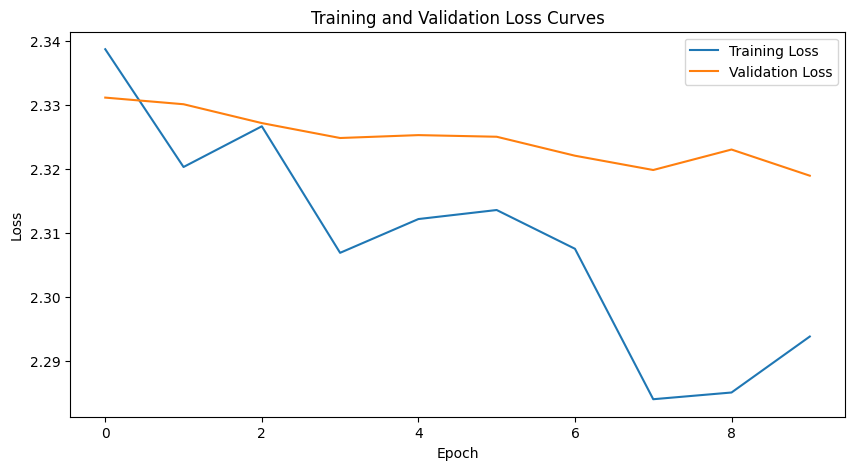

In [ ]:
# Example usage
model = SimpleNNWithDropout(activation_function=nn.ReLU(), dropout_rate=0.5)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)

# Train the model and capture the loss history
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10)

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curves')
plt.show()


## Step 9: Model Checkpointing
Model checkpointing allows you to save the model’s state whenever it achieves the best performance on the validation set.

### Instructions
1. During training, check if the validation loss is lower than the previous lowest validation loss.
2. If so, save the model using `torch.save()`.
3. Later, you can load the best model using `torch.load()` to evaluate or continue training from the best state.


In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=5, checkpoint_path='best_model.pth'):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')  # Initialize with infinity so any validation loss is lower
    
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_train_loss = 0.0
        
        # Training phase
        for images, labels in train_loader:
            optimizer.zero_grad()  # Clear the gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            running_train_loss += loss.item()  # Accumulate the training loss
        
        avg_train_loss = running_train_loss / len(train_loader)  # Average training loss for the epoch
        train_losses.append(avg_train_loss)
        
        # Validation phase
        avg_val_loss, val_accuracy = evaluate_model(model, criterion, val_loader)
        val_losses.append(avg_val_loss)
        
        # Check if current validation loss is the best we've seen so far
        if avg_val_loss < best_val_loss:
            print(f'Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...')
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), checkpoint_path)  # Save the model checkpoint
        
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    
    return train_losses, val_losses
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10)


In [ ]:
# Load the best model's state dictionary
best_model_path = 'best_model.pth'
model = SimpleNNWithDropout(activation_function=nn.ReLU(), dropout_rate=0.5)

# Load the best model weights
model.load_state_dict(torch.load(best_model_path))
print("Best model loaded from checkpoint.")

# Set model to evaluation mode if evaluating
model.eval()


Best model loaded from checkpoint.


SimpleNNWithDropout(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (activation_function): ReLU()
)

## Add Early Stopping Functionality
Pytorch's Early stopping function: https://pytorch.org/ignite/generated/ignite.handlers.early_stopping.EarlyStopping.html

In [ ]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=20, patience=5, checkpoint_path='best_model.pth'):

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_no_improve = 0  # Count epochs with no improvement in validation loss
    
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_train_loss = 0.0
        
        # Training phase
        for images, labels in train_loader:
            optimizer.zero_grad()  # Clear gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            running_train_loss += loss.item()  # Accumulate the training loss
        
        avg_train_loss = running_train_loss / len(train_loader)  # Average training loss for the epoch
        train_losses.append(avg_train_loss)
        
        # Validation phase
        avg_val_loss, val_accuracy = evaluate_model(model, criterion, val_loader)
        val_losses.append(avg_val_loss)
        
        # Check if this is the best validation loss
        if avg_val_loss < best_val_loss:
            print(f'Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...')
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), checkpoint_path)  # Save model checkpoint
        else:
            epochs_no_improve += 1
            print(f'No improvement for {epochs_no_improve} epochs.')

        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        
        # Early stopping condition
        if epochs_no_improve >= patience:
            print("Early stopping triggered. No improvement in validation loss for the last {} epochs.".format(patience))
            break
    
    return train_losses, val_losses


## Summary and Analysis
Reflect on your findings:
1. Which activation function performed best? Why do you think that is?
2. How did dropout and L2 regularization impact overfitting?
3. Which optimizer and learning rate combination led to the best performance?

### Key Takeaways
This practical has shown you how core components like activation functions, regularization, and optimization techniques affect a neural network's performance.
